In [1]:
# import libraries
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
# load data
data = pd.read_csv("shuffled-full-set-hashed.csv", names=['Category', 'Documents'])

BILL                       18959
POLICY CHANGE              10616
CANCELLATION NOTICE         9729
BINDER                      8952
DELETION OF INTEREST        4826
REINSTATEMENT NOTICE        4367
DECLARATION                  967
CHANGE ENDORSEMENT           889
RETURNED CHECK               749
EXPIRATION NOTICE            734
NON-RENEWAL NOTICE           624
BILL BINDER                  289
INTENT TO CANCEL NOTICE      229
APPLICATION                  229
Name: Category, dtype: int64


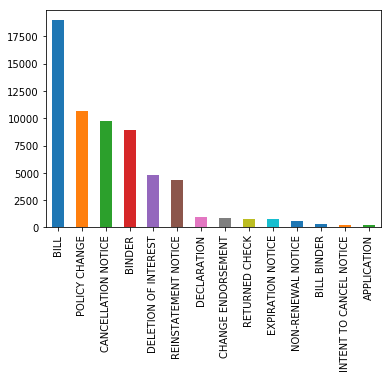

In [3]:
# clean the data by removing all NaN values
data.dropna(inplace=True)

# data exploration
pd.value_counts(data['Category']).plot.bar()
unique_categories = data['Category'].value_counts()
print(unique_categories)

In [4]:
# create respective lists of categories and documents
doc_type = data['Category'].values.tolist()
doc = data['Documents'].values.tolist()

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(doc, doc_type, test_size=0.3)

In [5]:
# tokenization - add all documents in a list
documents = []
for string in x_train:
    documents += string.split(" ")

In [6]:
# calculate the frequency
frequency = nltk.FreqDist(documents)
print(frequency)

<FreqDist with 794651 samples and 14591216 outcomes>


In [7]:
# store the documents having highest frequency
top_docs = frequency.most_common(250)
features = [i[0] for i in top_docs]
pickle.dump(features, open('feature.pkl', 'wb'))

In [8]:
# build a dictionary to respresent how many frequent words are present in a particular row 
def get_feature_dict(words):
    current_features = {}
    words_set = set(words)
    for w in features:
        current_features[w] = w in words_set
    return current_features

In [9]:
# convert arrays of training and testing data
training_set = []
for i in range(len(x_train)):
    training_set.append(((x_train[i]),y_train[i]))
testing_set = []
for i in range(len(x_test)):
    testing_set.append(((x_test[i]),y_test[i]))

In [10]:
# array of dictionary of training set 
training_data = [(get_feature_dict(string.split(" ")), category) for string,category in training_set]

In [12]:
# array of dictionary of testing set 
testing_data = [(get_feature_dict(string.split(" ")), category) for string, category in testing_set]

In [13]:
# Random Forest Classifier model
rfc = RandomForestClassifier()
rfc = RandomForestClassifier(n_estimators=90,min_samples_split=5,min_samples_leaf=2,max_features='auto',bootstrap=False)
RFC_classifier = SklearnClassifier(rfc)
RFC_classifier.train(training_data)
print("Accuracy:", (nltk.classify.accuracy(RFC_classifier, testing_data))*100)

Accuracy: 86.33097383097383


In [14]:
# save the classifier
pickle.dump(RFC_classifier, open('model.pkl', 'wb'))

In [15]:
# getting array of dictionaries of testing set
dict_testX = [(get_feature_dict(string.split(" "))) for string, category in testing_set]

In [16]:
# getting array of labels on testing set
ytest = [category for string, category in testing_set]

In [17]:
# predicted value from the classifier
prediction = RFC_classifier.classify_many(dict_testX)

In [18]:
matx = confusion_matrix(ytest, prediction)
print(matx)

[[  22    8    0   29    0    0    0    0    0    0    0    6    0    0]
 [   0 5128   14  122  213    2    9    1   13    3    1  190    3    2]
 [   0   37   17   17    0    0    0    0    0    0    0   17    0    0]
 [   1   69    1 2336    6    3   14    1    1    0    1  188    3    1]
 [   0  218    0   18 2517    0    5   76    1    8    1   57   42    0]
 [   0    1    0    9    2  215    0    0    0    0    0   39    2    0]
 [   0   50    1  125    8    1   51   12    1    0    1   41    5    2]
 [   0    1    0    5  105    1    0 1345    0    0    0   22    5    0]
 [   0   39    0    0    8    0    2    1  156    0    2    6    7    0]
 [   0   10    0    2   22    0    0    2    0   32    1    2    4    0]
 [   0    1    0    0   22    0    0    1    0    0  139   11    4    0]
 [   1  133    4  164   19   32    3   12    8    0    2 2807   13    0]
 [   0   20    0    3   37    0    2    2    2    0    0   53 1156    0]
 [   0   11    0    5    2    0    2    0    0    0